In [317]:
import numpy as np
import UsefulFunctions as uf
import pygmt
import pandas as pd
import xarray as xr
from pyproj import Transformer
import json

In [267]:
# functions needed for making the big grid and calculating distances (vectorized haversine + pythagorean theorem for 3d distance)

def trunc_float(nums, dec):
    truncated_nums = np.trunc(nums*10**dec)/10**dec
    
    return truncated_nums

def generate_grid(min_lat, max_lat, min_lon, max_lon, spacing_km):
    # convert km spacing to degrees, use average lat for longitude spacing
    lat_degree_spacing = trunc_float(spacing_km/111, 5)
    avg_lat = min_lat + (max_lat - min_lat)/2
    lon_degree_spacing = trunc_float(spacing_km/(111*np.cos(np.radians(avg_lat))), 5)
    
    lats = np.arange(min_lat, max_lat + lat_degree_spacing, lat_degree_spacing)
    lons = np.arange(min_lon, max_lon + lon_degree_spacing, lon_degree_spacing)
    lons_2d, lats_2d = np.meshgrid(lons, lats)
    grid = np.hstack((lats_2d.flatten().reshape(-1,1), lons_2d.flatten().reshape(-1,1)))

    return grid, lats, lons


def calculate_3d_distances(grid, other_points, depth):
    grid_latitudes = np.radians(grid[:, 0])
    grid_longitudes = np.radians(grid[:, 1])
    other_latitudes = np.radians(other_points[:, 0])
    other_longitudes = np.radians(other_points[:, 1])

    dlat = other_latitudes[:, None] - grid_latitudes
    dlon = other_longitudes[:, None] - grid_longitudes

    a = np.sin(dlat/2)**2 + np.cos(other_latitudes[:, None]) * np.cos(grid_latitudes) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distances_2d = 6371 * c  # 2D distances on the Earth's surface

    # Calculate 3D distances by adding depth component
    distances_3d = np.sqrt(distances_2d**2 + depth**2)

    return distances_3d

In [268]:
# vectorized functions needed for checking angles for a mass number of earthquake sources

def spherical_to_cartesian(lat, lon, depth):
    # Convert spherical coordinates (latitude, longitude, depth) to Cartesian coordinates (x, y, z)
    # lat_rad = np.radians(lat)
    # lon_rad = np.radians(lon)
    # x = np.cos(lat_rad) * np.cos(lon_rad) * (6371 - depth)
    # y = np.cos(lat_rad) * np.sin(lon_rad) * (6371 - depth)
    # z = np.sin(lat_rad) * (6371 - depth)
    
    # Just use a transformer from pyproj  (WGS84 > WGS Geocentric (XYZ))
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:4978")
    x, y, z = transformer.transform(lat, lon, depth)  # outputs in m

    return np.array([x, y, z]).T/1000. # convert back to km, transpose for columns instead of rows


def compute_3d_angles(stations, sources):
    # Convert stations and sources to Cartesian coordinates
    stations_cartesian = np.array([spherical_to_cartesian(*station) for station in stations])
    sources_cartesian = np.array([spherical_to_cartesian(*source) for source in sources])
    print(stations_cartesian.shape)
    print(sources_cartesian.shape)

    return result

# Example usage
# Assuming stations is a NumPy array of shape (n, 3) containing (latitude, longitude, depth) coordinates of stations
# and sources is a NumPy array of shape (m, 3) containing (latitude, longitude, depth) coordinates of sources



In [278]:
def calculate_detection_time(grid, stations_coords, depth, velP):
    max_gap = 60
    min_angle = 60
    # get distances to each station for each point
    distances_3d = calculate_3d_distances(grid, stations_coords, depth) 
    
#     sta_coords_cart = spherical_to_cartesian(stations_coords[:,0], stations_coords[:,1], stations_coords[:,2])
#     grid_coords_cart = spherical_to_cartesian(grid[:,0], grid[:,1], grid[:,2])

#     #initialize grid for stacking data
#     dists_and_sta_coords = np.empty((len(stations_coords), len(grid), 4))
#     # first pane is distance
#     dists_and_sta_coords[:,:,0] = distances_3d
#     # next 3 panes are coords
#     dists_and_sta_coords[:,:,1] = np.tile(sta_coords_cart[:, 0].reshape(-1,1), len(grid))
#     dists_and_sta_coords[:,:,2] = np.tile(sta_coords_cart[:, 1].reshape(-1,1), len(grid))
#     dists_and_sta_coords[:,:,3] = np.tile(sta_coords_cart[:, 2].reshape(-1,1), len(grid))

#     # sort columns of first panel (distances) and get the indices to use to reconstruct sorted array
#     ai = np.argsort(dists_and_sta_coords[:, :, 0], axis=0)
#     # initialize the new sorted array
#     dsc_sorted = np.empty((len(stations_coords), len(grid), 4))
#     # first pane is distance, next 3 are coords, same as before but sorted using the indices from argsort
#     dsc_sorted[:,:,0] = np.take_along_axis(dists_and_sta_coords[:,:,0], ai, axis=0)
#     dsc_sorted[:,:,1] = np.take_along_axis(dists_and_sta_coords[:,:,1], ai, axis=0)
#     dsc_sorted[:,:,2] = np.take_along_axis(dists_and_sta_coords[:,:,2], ai, axis=0)
#     dsc_sorted[:,:,3] = np.take_along_axis(dists_and_sta_coords[:,:,3], ai, axis=0)
    
#     # tile the grid coords so each point can be subtracted from each station coord (like a 3d meshgrid)
#     grid_tiled = np.empty((len(stations_coords), len(grid), 3))
#     grid_tiled[:, :, 0] = np.tile(grid_coords_cart[:, 0].reshape(-1, 1), len(stations_coords)).T
#     grid_tiled[:, :, 1] = np.tile(grid_coords_cart[:, 1].reshape(-1, 1), len(stations_coords)).T
#     grid_tiled[:, :, 2] = np.tile(grid_coords_cart[:, 2].reshape(-1, 1), len(stations_coords)).T    
    
#     # subtract each grid point coords from each station coords to get all displacement vectors
#     displacement_vectors_array = dsc_sorted[:, :, 1:] - grid_tiled
    
#     n = 4
#     # get dot products for first n stations
#     angles = np.ones(shape=(1,len(grid))) * np.radians(180)
#     dva_first_n = displacement_vectors_array[:n, :, :]
#     for i in range(n):
#         mag_i_arr = np.linalg.norm(dva_first_n[i,:,:], axis=1)
#         for j in range(i+1, n):
#             dot_prod_arr = np.sum(dva_first_n[i,:,:] * dva_first_n[j,:,:], axis=1)
#             mag_j_arr = np.linalg.norm(dva_first_n[j,:,:], axis=1)
#             mag_ij_arr = mag_i_arr * mag_j_arr
#             cos_angles = dot_prod_arr/mag_ij_arr
#             angles = np.vstack((angles, np.arccos(cos_angles).reshape(1,-1)))
#     # check which columns have an angle that meets the min_angle, then fill in other array
    
    
    detection_times_all = distances_3d/velP
    detection_times = np.sort(detection_times_all.T)[:, 3]
    return detection_times
    # return angles, dsc_sorted  # in radians


In [358]:
def calculate_blind_zone_radius(det_times, velS, d):
    R = (det_times + 4) * velS  # raidus of the travel distance sphere around the hypocenter
    r = np.sqrt((R**2 - d**2))  # radius of blind zone, if R < d then blind zone will be a complex num
    r[np.isnan(r)] = 0  #replace compelx nums with 0
    
    return r

In [288]:
def fourth_closest_station(grid, stations, depth):
    d3d = calculate_3d_distances(grid, stations, depth)
    d3d_sort = np.sort(d3d, axis=1)
    d3d_4c = d3d_sort[:, 3]
    return d3d_4c

In [431]:
depth = 50
velP = uf.Earthquake.vel_p
velS = uf.Earthquake.vel_s

stations = pd.read_csv('Data/EEWNetwork.csv')
stations_coords = np.vstack((stations.Lat, stations.Lon, np.zeros(shape=stations.Lat.shape))).T

# stations = uf.ActiveBBs
# stations_coords = np.vstack((stations.lat, stations.lon, np.zeros(shape=stations.lat.shape))).T

# Define the bounding box and spacing
min_lat = 49.5
max_lat = 72
min_lon = -196
max_lon = -129
spacing_km = 10  # Adjust as needed

# Generate the grid
grid, lats, lons = generate_grid(min_lat, max_lat, min_lon, max_lon, spacing_km)
grid = np.hstack((grid, np.ones((len(grid), 1)) * depth))


In [432]:
distances_3d = calculate_3d_distances(grid, stations_coords, depth) 


In [433]:
detection_times = calculate_detection_time(grid, stations_coords, depth, velP)

In [434]:
bz_rs = calculate_blind_zone_radius(detection_times, velS, depth)

/var/folders/g1/4874q8ms0w3fy6r8bcytvqgc0000gn/T/ipykernel_30955/3670786405.py:3: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt((R**2 - d**2))  # radius of blind zone, if R < d then blind zone will be a complex num


In [410]:
np.sort(distances_3d, axis=0)[3,:]

1.5225836439353206

In [422]:
print(lats)

[49.5     49.59009 49.68018 49.77027 49.86036 49.95045 50.04054 50.13063
 50.22072 50.31081 50.4009  50.49099 50.58108 50.67117 50.76126 50.85135
 50.94144 51.03153 51.12162 51.21171 51.3018  51.39189 51.48198 51.57207
 51.66216 51.75225 51.84234 51.93243 52.02252 52.11261 52.2027  52.29279
 52.38288 52.47297 52.56306 52.65315 52.74324 52.83333 52.92342 53.01351
 53.1036  53.19369 53.28378 53.37387 53.46396 53.55405 53.64414 53.73423
 53.82432 53.91441 54.0045  54.09459 54.18468 54.27477 54.36486 54.45495
 54.54504 54.63513 54.72522 54.81531 54.9054  54.99549 55.08558 55.17567
 55.26576 55.35585 55.44594 55.53603 55.62612 55.71621 55.8063  55.89639
 55.98648 56.07657 56.16666 56.25675 56.34684 56.43693 56.52702 56.61711
 56.7072  56.79729 56.88738 56.97747 57.06756 57.15765 57.24774 57.33783
 57.42792 57.51801 57.6081  57.69819 57.78828 57.87837 57.96846 58.05855
 58.14864 58.23873 58.32882 58.41891 58.509   58.59909 58.68918 58.77927
 58.86936 58.95945 59.04954 59.13963 59.22972 59.31

(251, 365)


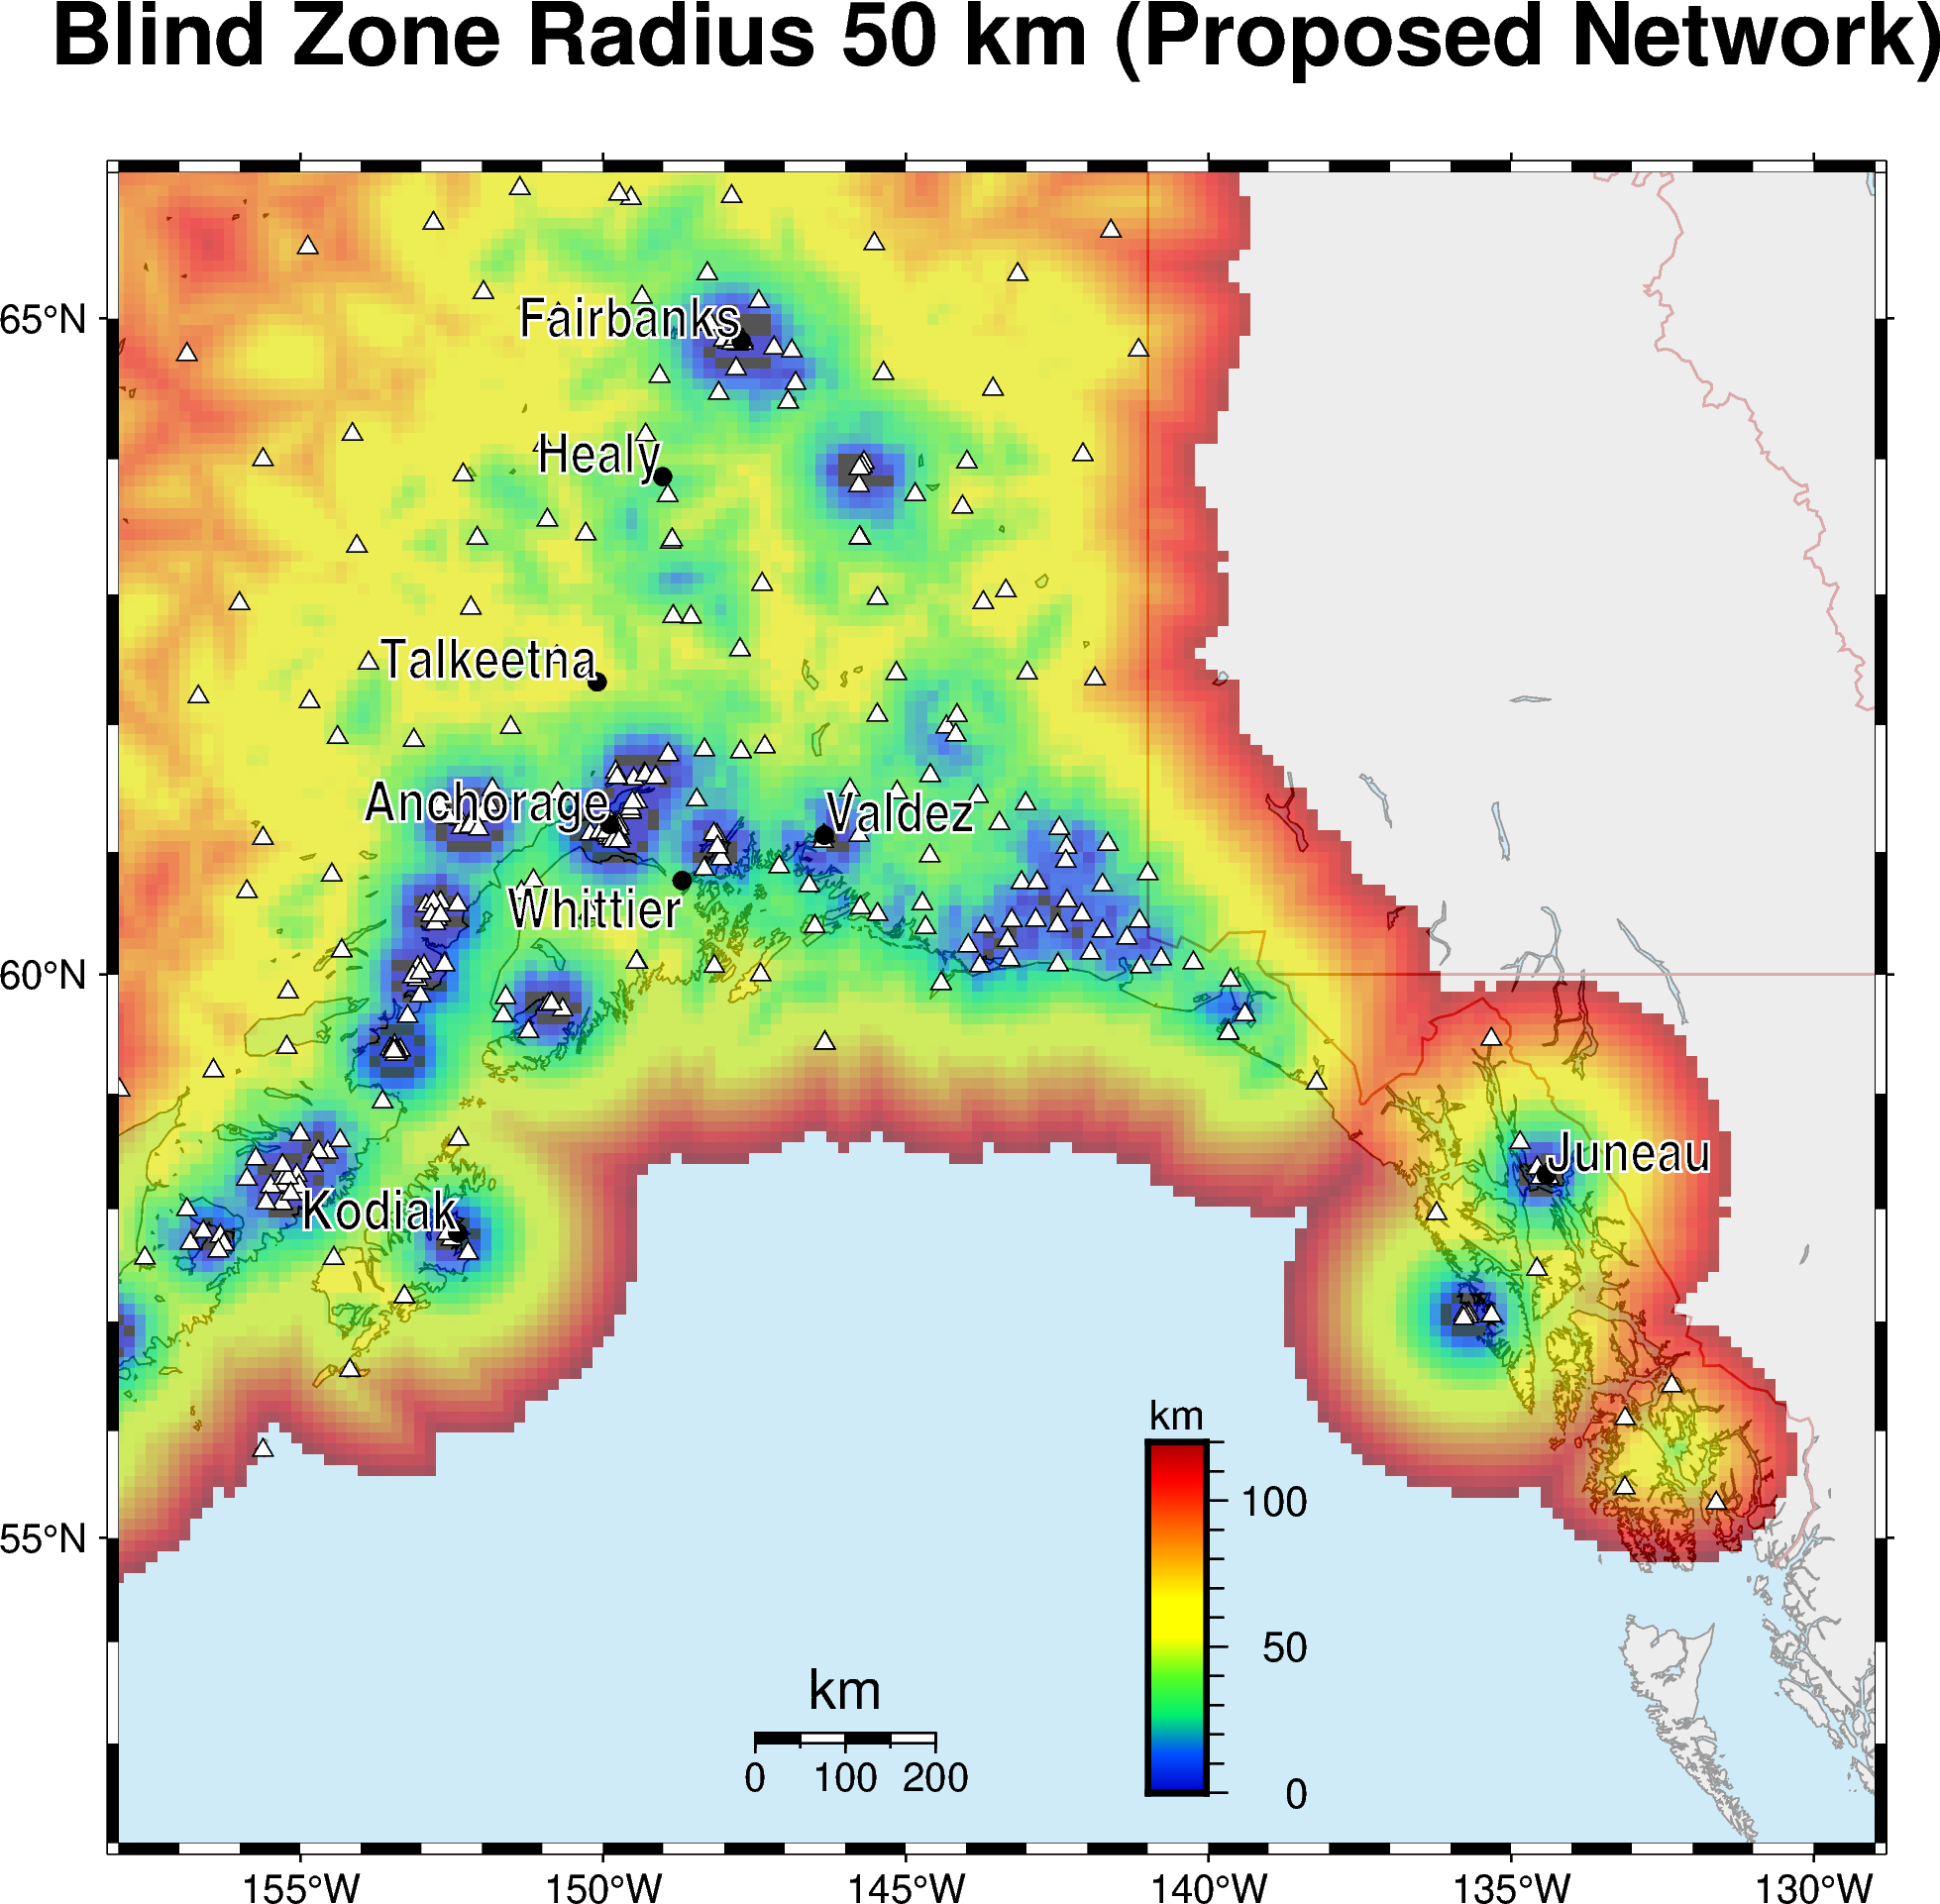

In [435]:
data = bz_rs.reshape(len(lats), -1)
# data = np.sort(distances_3d.T)[:, 3].reshape(len(lats), -1)
print(data.shape)
gridBoundaries = f'-158/{max_lon}/52/66'
# gridBoundaries = f'{min_lon}/{max_lon}/{min_lat}/{max_lat}'

title = f"Blind Zone Radius {depth} km (Proposed Network)"
coast_border = "a/0.5p,brown"
shorelines = "0.3p,black"
projection = 'M15c'
fig = pygmt.Figure()
# fig.basemap(region='170/49/-128/73+r', projection='M15c', frame=["af", f'WSne+t"{title}"'])
# fig.basemap(region=gridBoundaries, projection=projection, frame=["af", f'WSne+t"{title}"'], map_scale="jBL+w500k+o1c/1c+f")
fig.basemap(region=gridBoundaries, projection=projection, frame=["af", f'WSne+t"{title}"'])

fig.coast(shorelines=shorelines, borders=coast_border, water='skyblue', land='lightgray')  # draw coast over datawater='skyblue'

vmin = 0
vmax = 120
pygmt.makecpt(
    cmap=['seis'],
    reverse=True,
    series=[vmin, vmax],
    no_bg=True
    )

data_array = xr.DataArray(data=data, 
                          dims=['lat', 'lon'],
                          coords=dict(lon=(['lon'], lons),
                                      lat=(['lat'], lats)))

# masked_data_array = xr.where((data_array < vmin) | (data_array > vmax), np.nan, data_array)

fig.grdimage(grid=data_array,
             projection=projection,
             region=gridBoundaries,
             cmap=True, 
             transparency=40)

fig.plot(  # Plot seismic stations as triangles
    x=stations['Lon'],
    y=stations['Lat'],
    style='t+0.2c',
    color='white',
    pen='black',
)

with open('Data/Interior Crustal/Old Interior Community Data.json') as json_file:
    comm_dict = json.load(json_file)
# plot communities
for name, data in comm_dict.items():
    if name in ['Glennallen', 'North Pole', 'Eielson Air Force Base', 'Clear Space Force Station', 'Fort Wainwright', 'Fort Greely', 'Cantwell']:
        continue
    fig.plot(
        x=data['latlon'][1],
        y=data['latlon'][0],
        style='c0.16c',
        color='black'
    )
    if name.lower() in ['anchorage']:
        corner = 'BR'
        adjust = 0.025
    elif name.lower() in ['whittier']:
        corner = 'TR'
        adjust = -0.05
    else:
        corner = 'BR'
        adjust = 0.025
    fig.text(
        x=data['latlon'][1],
        y=data['latlon'][0] + adjust,
        text=name,
        font='14p,Helvetica-Narrow-Bold,black,=0.5p,white',
        justify=corner
    )
others = [('Kodiak', 57.7900, -152.4072), ('Valdez', 61.1309, -146.3499), ('Juneau', 58.3005, -134.4201)]
for comm in others:
    name = comm[0]
    lat = comm[1]
    lon = comm[2]
    if name in ['Juneau', 'Valdez']:
        corner = 'BL'
    fig.plot(
            x=lon,
            y=lat,
            style='c0.16c',
            color='black'
        )
    fig.text(
            x=lon,
            y=lat + adjust,
            text=name,
            font='14p,Helvetica-Narrow-Bold,black,=0.5p,white',
            justify=corner
        )

fig.colorbar(
    position='g-141/52.5+w3c/0.5c+v',
    frame=['x','ya5f2.5+lkm']
)
fig.basemap(region=gridBoundaries, projection=projection, map_scale="g-146/53+w200k+f+lkm")

fig.show()
fig.savefig(f'Figures/misc/Blind Zone Radius {depth} km Proposed Network.pdf')

In [ ]:
gridBoundaries = f'{min_lon-0.5}/{max_lon+0.5}/{min_lat-0.5}/{max_lat+0.5}'
title = f"Detection Times at {depth} km Depth"
coast_border = "a/0.5p,brown"
shorelines = "0.3p,black"
fig = pygmt.Figure()
# fig.basemap(region='170/49/-128/73+r', projection='M15c', frame=["af", f'WSne+t"{title}"'])
fig.basemap(region=gridBoundaries, projection='M15c', frame=["af", f'WSne+t"{title}"'])

fig.coast(shorelines=shorelines, borders=coast_border, water='skyblue', land='lightgray')  # draw coast over datawater='skyblue'

pygmt.makecpt(
    transparency=75,
    cmap=['seis'],
    reverse=True,
    series=[0, 60]  # np.max(p[2, :])
)
data_array = xr.DataArray(data=dt_2d, 
                          dims=['lat', 'lon'],
                          coords=dict(lon=(['lon'], lons),
                                      lat=(['lat'], lats)))
fig.grdimage(grid=data_array,
             projection='M15c',
             region=gridBoundaries,
             cmap=True)

fig.plot(  # Plot seismic stations as triangles
    x=stations['lon'],
    y=stations['lat'],
    style='t+0.3c',
    color='white',
    pen='black',
)

fig.show()
fig.savefig(f'Figures/misc/detection time map {depth} km depth.pdf')

In [ ]:
# sta_lats = np.array(stations['lat'])
# sta_lons = np.array(stations['lon'])
# print(np.array(stations['lon']).shape)
# num_p = len(grid_lons)
# num_sta = len(sta_lons)
# grid_lons_2D = np.reshape(grid_lons, (num_p, 1))
# grid_lats_2D = np.reshape(grid_lats, (num_p, 1))

# sta_lons_2D = np.zeros(shape=(num_p, num_sta))
# sta_lats_2D = np.zeros(shape=(num_p, num_sta))
# for i in range(num_p):
#     sta_lons_2D[i,:] = sta_lons
#     sta_lats_2D[i,:] = sta_lats
# print(grid_lons_2D.shape)
# print(sta_lons_2D.shape)